In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import sys
sys.path.append('../code')
from plotutils import *

In [2]:
"""
Load the tap brain model
"""
#brain_name = 'Ns_25_noiseseed_2041'
#brain_name = 'Ns_25_noiseseed_6899'
#brain_name = 'Ns_25_noiseseed_5539'
brain_name = 'Ns_25_noiseseed_4021'
use_cuda = False
tapbrain, theta, params = loadbrain('../data/brains/' + brain_name, use_cuda)

Ns = params['Ns']
Ny = params['Ny']
Nr = params['Nr']

lam, G, J, U, V = extractParams(theta, 18, Ns, Ny, Nr)
 
# process and observation noise covariance matrices and update it in params
q_process, q_obs = 1e-5, 1e-2
Q_process, Q_obs = q_process*np.eye(Ns), q_obs*np.eye(Nr)  
params['Q_process'] = Q_process
params['Q_obs'] = Q_obs

# Set noise seed
noise_seed = np.random.randint(10000)
#noise_seed = 9397 # try this noise seed
np.random.seed(noise_seed)
torch.manual_seed(noise_seed)
print('noise_seed = %d' %(noise_seed))

# model_type -- 1: Ux + b, 0: Ux
model_type = 1 if np.any(U<0) else 0
baseline = params['baseline'] if model_type else 0

noise_seed = 9391


In [3]:
"""
Generate measurements using high gain inputs.
These measurements will be used to obtain an initial estimate of the embedding matrix.
"""

B, T = 2000, 50 
T_low, T_high = 2, 5
yG_low, yG_high = 50, 50
T_clip = 20
r_ICA = generate_TAPbrain_dynamics(tapbrain,theta, params, B, T, T_low, T_high, yG_low, yG_high, T_clip, use_cuda)[2]

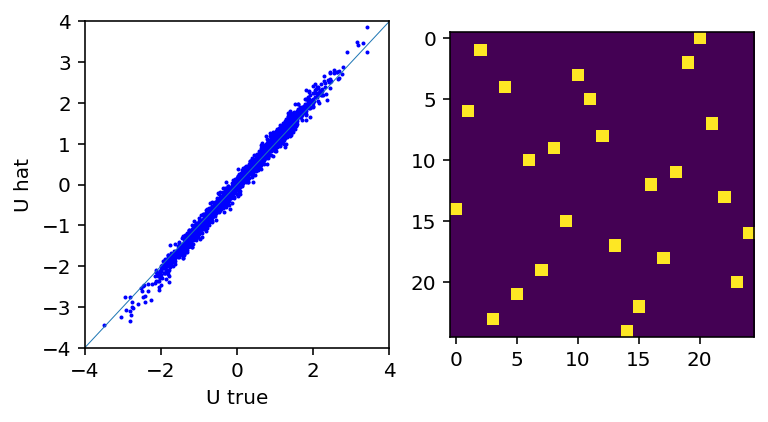

In [4]:
"""
Use ICA to get initial estimate of the embedding
"""
b_init = np.mean(r_ICA) if model_type else 0
U_init = UhatICA(np.reshape(r_ICA.transpose(1,2,0)-b_init,[Nr,T*B],order='F').T, Ns)[0]
#del r_ICA

PermMat_init = EstimatePermutation_ICA(U,U_init) # Estimate the permutation matrix P

"""
Generate random initial estimates of the parameters 
"""
G_init    = np.zeros([18])
J_init    = 0.1*Create_J(Ns, 0, params['Jtype'], params['self_coupling_on'])  # create a fully connected initial J with small initial values
if Ns <= Ny:
    V_init = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[2]
else:
    V_init = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[0]


# Plot estimate of embedding and permutation matrix
umax = np.ceil(np.max(U))
umin = np.floor(np.min(U))

fig, ax = plt.subplots(1,2,figsize=(6,3))
ax[0].plot(U.flatten(),np.dot(U_init,PermMat_init).flatten(),'b.',markersize=2)
ax[0].plot([umin,umax],[umin,umax],Linewidth=0.5)
ax[0].axis([umin,umax,umin,umax])
ax[0].set(xlabel='U true', ylabel='U hat')
ax[1].imshow(PermMat_init)
plt.show()

In [5]:
"""
Generate measurements for the particle EM algorithm
"""
B, T = 20000, 25
yG_low, yG_high = 2, 25

y, x, r_brain = generate_TAPbrain_dynamics(tapbrain,theta, params, B, T, T_low, T_high, yG_low, yG_high, T_clip, use_cuda)

mean SNR = 104.1


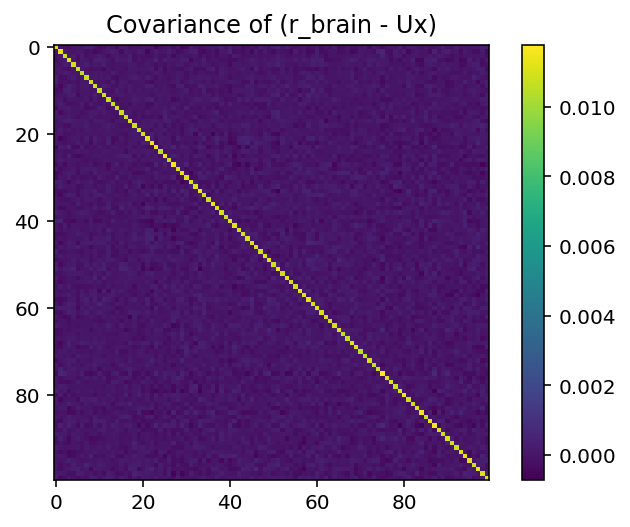

In [6]:
"""
SNR checks
"""
SNR, C_sig, C_err = computeSNR(r_brain-baseline, x, U)
print('mean SNR = %.1f' %(SNR))

plt.imshow(C_err)
plt.title('Covariance of (r_brain - Ux)')
plt.colorbar()
plt.show()

In [7]:
"""
Inspect and update update Q_obs. Later insert heuristic to estimate Q_obs
"""
print('mean variance of measurement noise = %.3f' %(np.mean(np.diag(C_err))))
# Q_obs = np.mean(np.diag(C_err))*np.eye(Nr)
Q_obs = np.diag(np.diag(C_err))


mean variance of measurement noise = 0.011


In [8]:
"""
Convert data to torch tensors
"""
device, dtype = "cpu", torch.float64

Q_process = torch.tensor(Q_process,device=device,dtype=dtype)
Q_obs     = torch.tensor(Q_obs,device=device,dtype=dtype)

P_process = Q_process.inverse()
P_obs     = Q_obs.inverse()

r_brain   = torch.tensor(r_brain,device=device,dtype=dtype)
y         = torch.tensor(y,device=device,dtype=dtype)

lam       = torch.tensor(lam,device=device,dtype=dtype,requires_grad=False)

G      = torch.tensor(G,device=device,dtype=dtype,requires_grad=False)
J      = torch.tensor(J,device=device,dtype=dtype,requires_grad=False)
U      = torch.tensor(U,device=device,dtype=dtype,requires_grad=False)
V      = torch.tensor(V,device=device,dtype=dtype,requires_grad=False)

G_hat  = torch.tensor(G_init,device=device,dtype=dtype,requires_grad=True)
U_hat  = torch.tensor(U_init,device=device,dtype=dtype,requires_grad=True)
V_hat  = torch.tensor(V_init,device=device,dtype=dtype,requires_grad=True)
J_hat_vec = torch.tensor(JMatToVec(J_init),device=device,dtype=dtype,requires_grad=True)
J_hat = JVecToMat_torch(J_hat_vec,Ns)
b_hat = torch.tensor(b_init,device=device,dtype=dtype,requires_grad=True) if model_type else 0

In [9]:
"""
Run PF with true values of parameters
""" 
Np = 100 # No. of particles to use

B_plot = 100 if B>100 else B

with torch.no_grad():
    LL_tp, x_tp, P_tp, W_tp = particlefilter(G, J, U, V, lam, r_brain[0:B_plot]-baseline, y[0:B_plot], P_process, P_obs, Np)

r_tp = torch.matmul(U,x_tp) + baseline
    
"""
Run PF with initial values of parameters
"""
t_st = time.time()
with torch.no_grad():
    LL_hat, x_hat, P_hat, W_hat = particlefilter(G_hat, J_hat, U_hat, V_hat, lam, r_brain[0:B_plot]-b_init, y[0:B_plot], P_process, P_obs, Np)
t_en = time.time()

print('time elapsed = %.2f s' %(t_en - t_st))

print('log likelihood with true parameters = %.1f' %(LL_tp.mean().data.numpy()))
print('log likelihood with initial parameters = %.1f' %(LL_hat.mean().data.numpy()))

# make a copy of the latent dynamics and fits to neural activity obtained using initial estimates of the parameters
x_init = x_hat*1.0
r_init = torch.matmul(U_hat,x_hat) + b_init

time elapsed = 6.30 s
log likelihood with true parameters = -1135.7
log likelihood with initial parameters = -253860.2


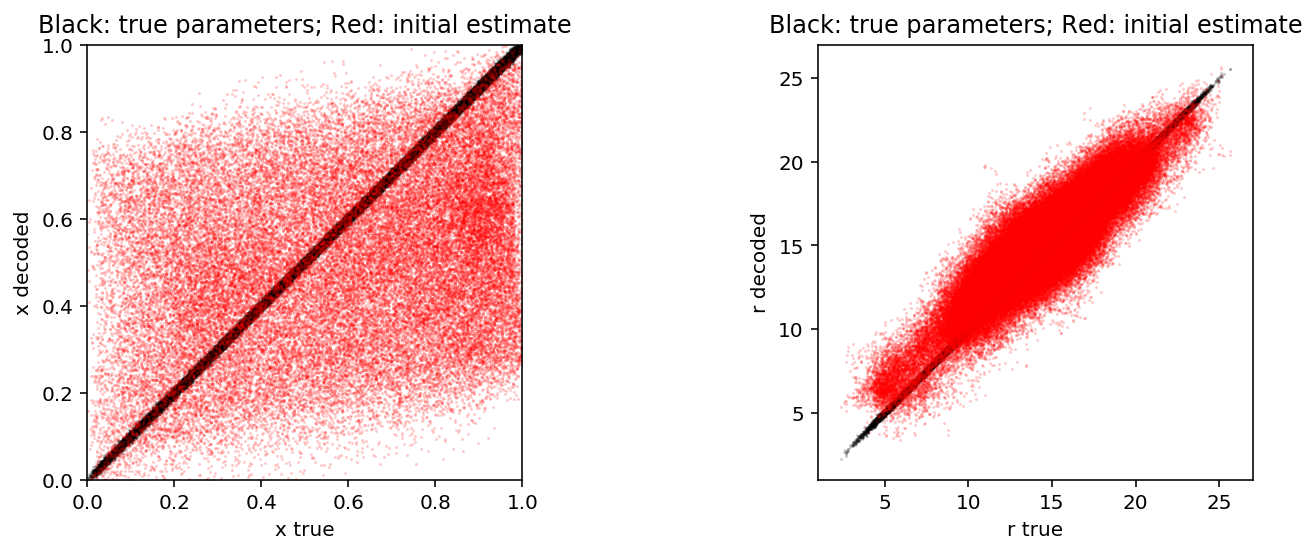

In [10]:
"""
Plot comparison of latent states decoded by the PF using initial value of parameters vs. ground truth
"""

T_st = 5 # discard the first T_st samples from each batch for comparisons

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(x[0:B_plot,:,T_st:].flatten(), x_tp[...,T_st:].data.numpy().flatten(),'k.',markersize=1,alpha=0.2)
P_temp = torch.tensor(PermMat_init.T,device=device,dtype=dtype,requires_grad=False)
ax[0].plot(x[0:B_plot,:,T_st:].flatten(), torch.matmul(P_temp, x_init[...,T_st:]).data.numpy().flatten(),'r.',markersize=1,alpha=0.2)
ax[0].set(xlabel='x true', ylabel='x decoded')
ax[0].set_title('Black: true parameters; Red: initial estimate')
ax[0].axis('square')
ax[0].axis([0,1,0,1])

rmax = np.round(r_brain.max().item())
rmin = np.round(r_brain.min().item())

ax[1].plot(r_brain[0:B_plot,:,T_st:].data.numpy().flatten(),r_tp[...,T_st:].data.numpy().flatten(),'k.',markersize=1,alpha=0.2)
ax[1].plot(r_brain[0:B_plot,:,T_st:].data.numpy().flatten(),r_init[...,T_st:].data.numpy().flatten(),'r.',markersize=1,alpha=0.2)
ax[1].set(xlabel='r true', ylabel='r decoded')
ax[1].set_title('Black: true parameters; Red: initial estimate')
ax[1].axis('square')
ax[1].axis([rmin,rmax,rmin,rmax])

plt.show()

## run particle EM

In [11]:
lrate       = 4e-3
NIterations = 25000

if model_type:
    opt_params = [G_hat,J_hat_vec,U_hat, V_hat, b_hat]
else:
    opt_params = [G_hat,J_hat_vec,U_hat, V_hat]

optimizer  = torch.optim.Adam(opt_params,lr=lrate, betas=(0.9, 0.999))

batch_size = 3

LLVec      = [] #record the log likelihoods

t_st = time.time()

for iteration in range(NIterations):
    
    if iteration == NIterations//2:
        optimizer  = torch.optim.Adam(opt_params,lr=lrate/4, betas=(0.9, 0.999))

    if iteration == 3*NIterations//4:
        optimizer  = torch.optim.Adam(opt_params,lr=lrate/16, betas=(0.9, 0.999))
        
        
    #zero-gradients at the start of each epoch
    optimizer.zero_grad() 
    
    # select indices of batches
    idx = np.random.randint(low=0,high=B,size=batch_size)
    
    # run particle filter to get posterior for E-step
    with torch.no_grad():
        LL_b, x_b, P_b, W_b = particlefilter(G_hat, JVecToMat_torch(J_hat_vec,Ns), U_hat, V_hat, lam, r_brain[idx]-b_hat, y[idx], P_process, P_obs, Np)

        
    # E-step
    C = Qfunction(G_hat, JVecToMat_torch(J_hat_vec,Ns), U_hat, V_hat, lam, r_brain[idx,:,T_st:]-b_hat, y[idx,:,T_st:], P_b[...,T_st:], W_b, P_process, P_obs)
    
    # M-step
    C.backward() 
    G_hat.grad[0], G_hat.grad[9] = 0, 0 # set gradient of G0 and G9 to zero
    optimizer.step()
    
    # record the log likelihood
    if (iteration+1)%500 == 0:
        with torch.no_grad():
            LL_rec = particlefilter(G_hat, JVecToMat_torch(J_hat_vec,Ns), U_hat, V_hat, lam, r_brain[0:B_plot]-b_hat, y[0:B_plot], P_process, P_obs, Np)[0]
            LLVec.append(LL_rec.mean())
             
    
    if (iteration+1) % 1000 == 0:
        print('[%d] log likelihood: %.1f' %(iteration + 1, LL_rec.mean()))
        
        
t_en = time.time()

print('Finished training')
print('Time elapsed = %.1f mins'%((t_en - t_st)/60))

[1000] log likelihood: -1994.4
[2000] log likelihood: -1517.1
[3000] log likelihood: -1422.8
[4000] log likelihood: -1412.1
[5000] log likelihood: -1401.3
[6000] log likelihood: -1391.1
[7000] log likelihood: -1425.5
[8000] log likelihood: -1345.2
[9000] log likelihood: -1364.1
[10000] log likelihood: -1402.3
[11000] log likelihood: -1381.0
[12000] log likelihood: -1393.1
[13000] log likelihood: -1197.4
[14000] log likelihood: -1193.3
[15000] log likelihood: -1197.8
[16000] log likelihood: -1184.2
[17000] log likelihood: -1190.2
[18000] log likelihood: -1192.9
[19000] log likelihood: -1154.1
[20000] log likelihood: -1150.1
[21000] log likelihood: -1151.9
[22000] log likelihood: -1151.5
[23000] log likelihood: -1152.8
[24000] log likelihood: -1153.5
[25000] log likelihood: -1152.1
Finished training
Time elapsed = 153.4 mins


In [12]:
"""
Run the PF on all the data
"""

B_plot = 100
J_hat = JVecToMat_torch(J_hat_vec,Ns)
with torch.no_grad():
    LL_hat, x_hat, P_hat, W_hat = particlefilter(G_hat, J_hat, U_hat, V_hat, lam, r_brain[0:B_plot]-b_hat, y[0:B_plot], P_process, P_obs, Np)

print('log likelihood with inferred parameters = %.1f' %(LL_hat.mean().data.numpy()))


log likelihood with inferred parameters = -1151.3


## Visualizing results

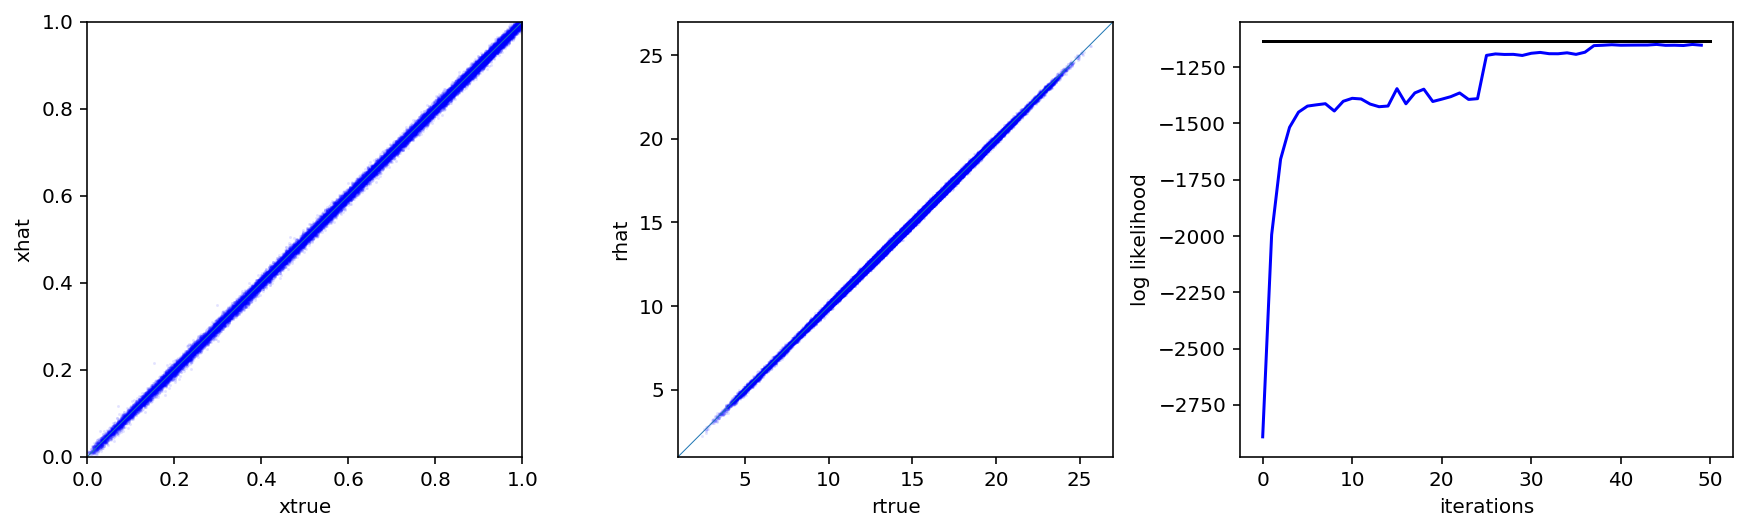

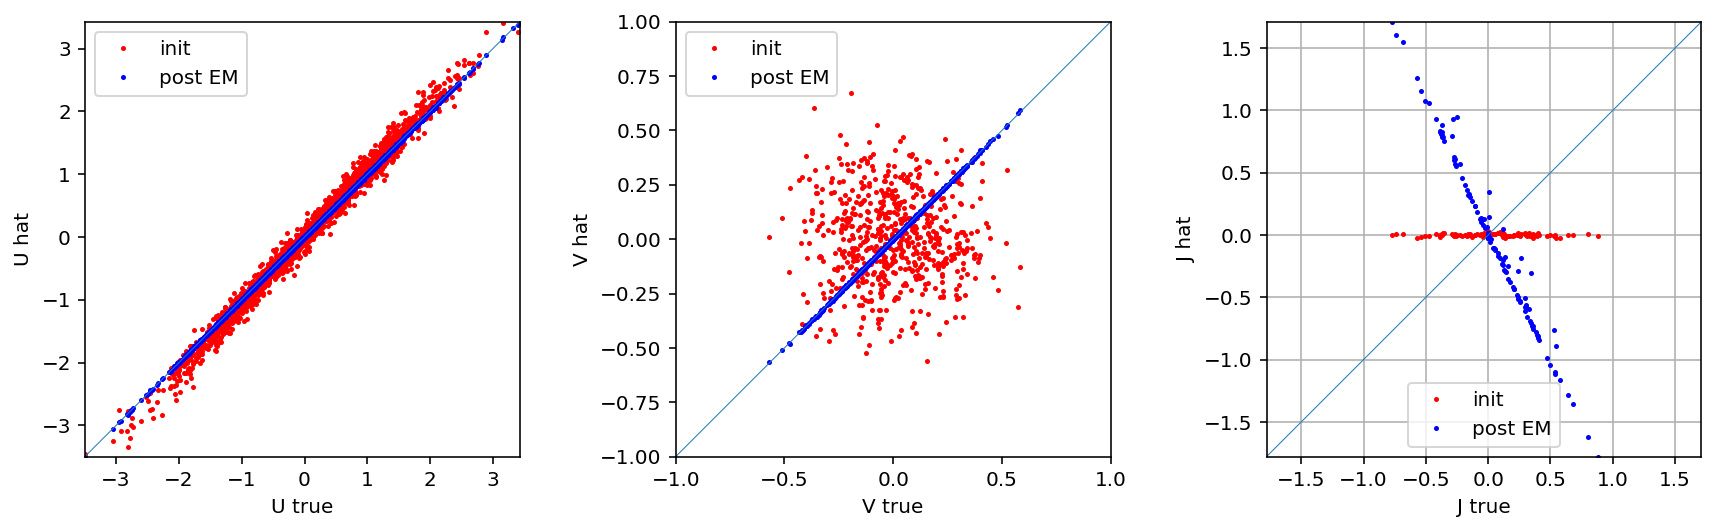

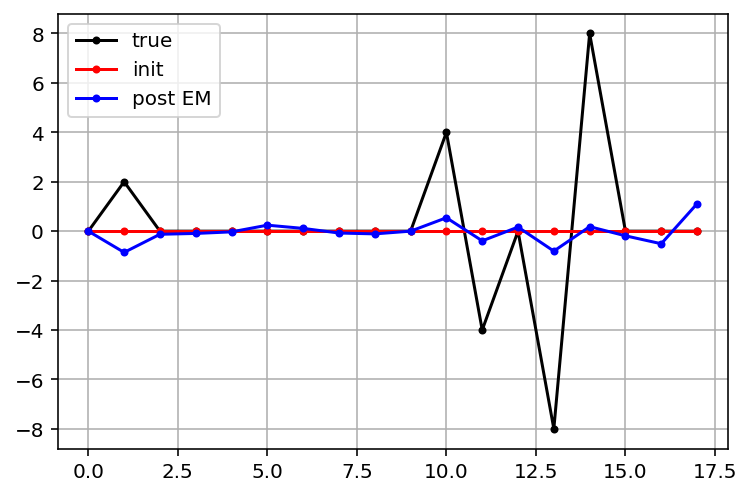

In [32]:
"""
Plotting results
"""

G_hat_ = G_hat.detach().cpu().data.numpy()
J_hat_ = J_hat.detach().cpu().data.numpy()
U_hat_ = U_hat.detach().cpu().data.numpy()
V_hat_ = V_hat.detach().cpu().data.numpy()

# Estimate PermMat again
PermMat = EstimatePermutation_ICA(U.data.numpy(),U_hat_)

# fit to neural activity
r_hat_ = (torch.matmul(U_hat,x_hat) + b_hat).data.numpy()


# figure 1
x_hat_ = x_hat.permute(1,2,0).data.numpy()
fig, ax = plt.subplots(1,3,figsize=(15,4))
P_temp = torch.tensor(PermMat.T,device=device,dtype=dtype,requires_grad=False)
ax[0].plot(x[0:B_plot,:,T_st:].flatten(), torch.matmul(P_temp, x_hat[...,T_st:]).data.numpy().flatten(),'b.',markersize=1,alpha=0.1)
ax[0].plot([0,1],[0,1],linewidth=0.5)
ax[0].set(xlabel='xtrue', ylabel='xhat')
ax[0].axis('square')
ax[0].axis([0,1,0,1])

ax[1].plot(r_brain[0:B_plot,:,T_st:].data.numpy().flatten(),r_hat_[...,T_st:].flatten(),'b.',markersize=1,alpha=0.1)
ax[1].plot([rmin,rmax],[rmin,rmax],linewidth=0.5)
ax[1].set(xlabel='rtrue', ylabel='rhat')
ax[1].axis('square')
ax[1].axis([rmin,rmax,rmin,rmax])

ax[2].plot(torch.stack(LLVec).data.numpy(),'b')
ax[2].plot([0,len(LLVec)],LL_tp.mean().item()*np.ones([2]),'k')
ax[2].set(xlabel='iterations', ylabel='log likelihood')

plt.show()

# Figure 2
Jmax = max(np.max(J.data.numpy()),np.max(J_hat_))
Jmin = min(np.min(J.data.numpy()),np.min(J_hat_))
Jhat = J_hat_*0
Jinit = J_init*0 # shuffle Jinit also
x_idx = np.dot(PermMat.T, np.arange(Ns))

for ii in range(Ns):
    for jj in range(Ns):
        Jhat[ii,jj] = J_hat_[np.int(x_idx[ii]),np.int(x_idx[jj])]
        Jinit[ii,jj] = J_init[np.int(x_idx[ii]),np.int(x_idx[jj])]
                          

fig, ax = plt.subplots(1,3,figsize=(15,4))
umax = U.max().item()
umin = U.min().item()

ax[0].plot(U.numpy().flatten(),np.dot(U_init,PermMat_init).flatten(),'r.',markersize=3)
ax[0].plot(U.numpy().flatten(),np.dot(U_hat_,PermMat).flatten(),'b.',markersize=3)
ax[0].axis('square')
ax[0].plot([umin,umax],[umin,umax],Linewidth=0.5)
ax[0].axis([umin,umax,umin,umax])
ax[0].set(xlabel='U true', ylabel='U hat')
ax[0].legend(['init', 'post EM'])

ax[1].plot(V.numpy().flatten(),np.dot(PermMat.T, V_init).flatten(),'r.',markersize=3)
ax[1].plot(V.numpy().flatten(),np.dot(PermMat.T, V_hat_).flatten(),'b.',markersize=3)
ax[1].axis('square')
ax[1].plot([-1,1],[-1,1],linewidth=0.5)
ax[1].axis([-1,1,-1,1])
ax[1].set(xlabel='V true', ylabel='V hat')
ax[1].legend(['init', 'post EM'])

ax[2].plot(JMatToVec_torch(J).numpy(),JMatToVec(Jinit),'r.',markersize=3)
ax[2].plot(JMatToVec_torch(J).numpy(),JMatToVec(Jhat),'b.',markersize=3)
ax[2].axis('square')
ax[2].plot([Jmin,Jmax],[Jmin,Jmax],linewidth=0.5)
ax[2].axis([Jmin,Jmax,Jmin,Jmax])
ax[2].set(xlabel='J true', ylabel='J hat')
ax[2].legend(['init', 'post EM'])
ax[2].grid(True)
#plt.savefig('Parameters.pdf')
plt.show()

# Plot G 
plt.plot(G.data.numpy(),'k.-')
plt.plot(G_init,'r.-')
plt.plot(G_hat_,'b.-')
plt.legend(['true','init','post EM'])
plt.grid(True)
#plt.savefig('G.pdf')
plt.show()

In [14]:
# normalize J and G
J_true_vec = JMatToVec(J.data.numpy())
z = np.polyfit(J_true_vec, JMatToVec(Jhat),1)

# normalize G_hat and J_hat
J_hat_normalized = (JMatToVec(Jhat) - z[1])/z[0]

G_hat_normalized = G_hat_*1.0
G_hat_normalized[0:9] = z[0]*G_hat_[0:9] + 2*z[0]*z[1]*G_hat_[9:]
G_hat_normalized[9:] = (z[0]**2)*G_hat_[9:]

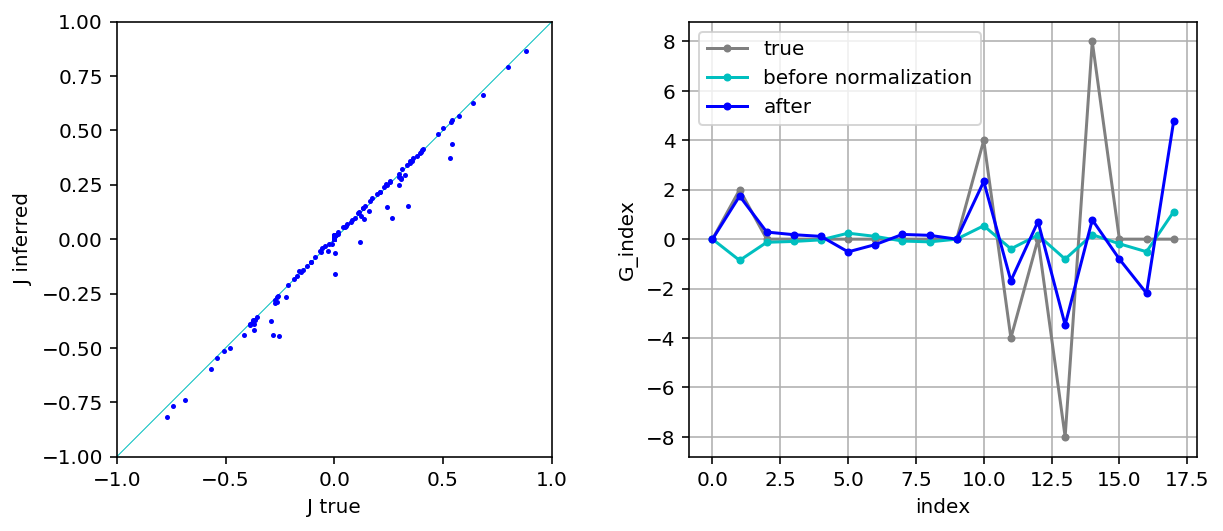

In [19]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot([-1,1],[-1,1],'c',linewidth=0.5)
ax[0].plot(J_true_vec,J_hat_normalized,'b.',markersize=3)
ax[0].axis('square')
ax[0].axis([-1,1,-1,1])
ax[0].set(xlabel='J true',ylabel='J inferred')
ax[1].plot(G.data.numpy(),'.-',color='gray')
ax[1].plot(G_hat.data.numpy(),'c.-')
ax[1].plot(G_hat_normalized,'b.-')
ax[1].grid(True)
ax[1].set(xlabel = 'index', ylabel = 'G_index')
ax[1].legend(['true','before normalization','after'])
plt.savefig('NormalizedJG.pdf')
plt.show()

In [41]:
"""
Validate on new measurements
"""

B_val = 100
T_clip = 0
y_val = generate_Input(params, B_val, T+T_clip, T_low, T_high, yG_low, yG_high)

x0 = np.random.rand(Ns,B_val) # initial values

# Run TAP dynamics using true theta
x_val 	= runTAP(x0, y_val, Q_process.data.numpy(), Q_obs.data.numpy(), theta, params['nltype'])

# Run TAP dynamics using inferred theta
theta_hat = np.concatenate([np.array([lam]), G_hat_, JMatToVec(Jhat), np.dot(U_hat_,PermMat).flatten('F'), np.dot(PermMat.T, V_hat_).flatten('F') ])
x_hat_val = runTAP(x0, y_val, Q_process.data.numpy(), Q_obs.data.numpy(), theta_hat, params['nltype'])

x_val = x_val[...,T_clip:].transpose(1,2,0)
x_hat_val = x_hat_val[...,T_clip:].transpose(1,2,0)
truth = x_val.flatten()
test = x_hat_val.flatten()

RMSE = 0.007


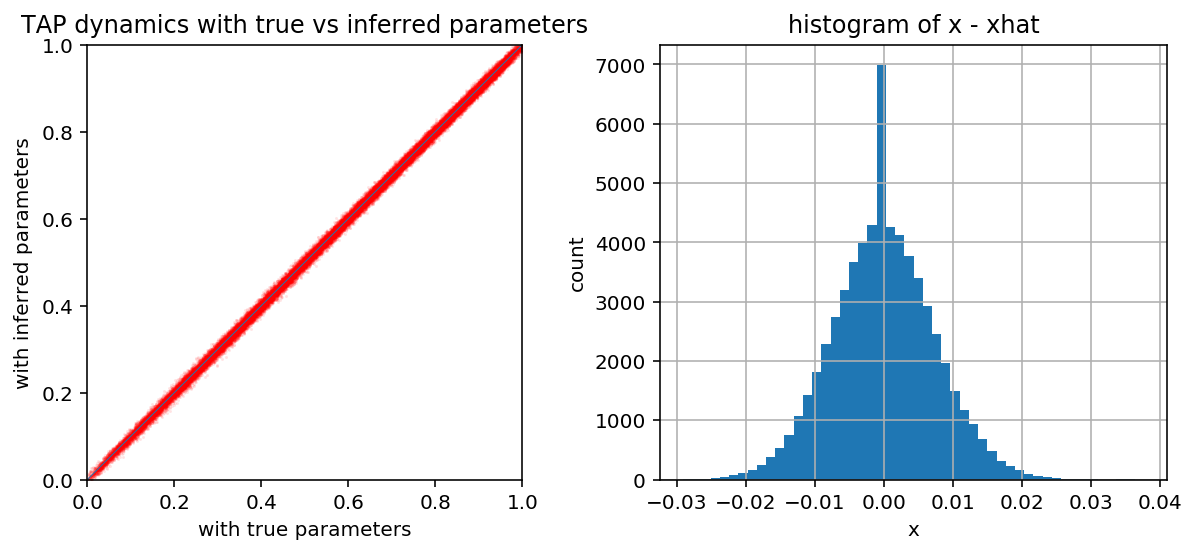

In [42]:
"""
Plot results on test set
"""

print('RMSE = %.3f' %(np.sqrt(np.mean((truth - test)**2))))

fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].plot(truth,test,'r.',markersize=1,alpha=0.1)
ax[0].plot([0,1],[0,1],linewidth=0.5)
ax[0].set(xlabel='with true parameters', ylabel='with inferred parameters', title='TAP dynamics with true vs inferred parameters')
ax[0].axis('square')
ax[0].axis([0,1,0,1])

ax[1].hist(truth-test,50)
ax[1].set(xlabel = 'x', ylabel = 'count', title = 'histogram of x - xhat')
ax[1].grid(True)
#ax[1].axis([-0.1,0.1,0,25000])
#plt.savefig('Xvalidation.pdf')
plt.show()

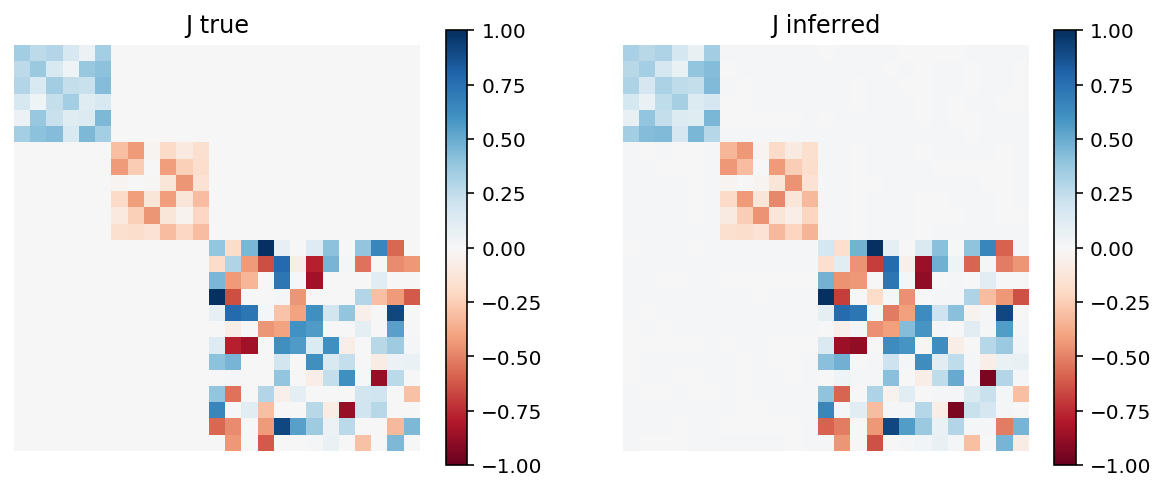

In [43]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
pcm = ax[0].imshow(J.data.numpy()/J.abs().max().item(),vmin=-1,vmax=1,cmap='RdBu')
ax[0].set(title='J true')
ax[0].axis('off')
fig.colorbar(pcm, ax=ax[0])
JMat_normalized = JVecToMat(J_hat_normalized,Ns)
pcm = ax[1].imshow(JMat_normalized/np.max(np.abs(JMat_normalized)),vmin=-1,vmax=1,cmap='RdBu')
ax[1].set(title='J inferred')
ax[1].axis('off')
fig.colorbar(pcm, ax=ax[1])
#plt.savefig('Jestimates.pdf')
plt.show()

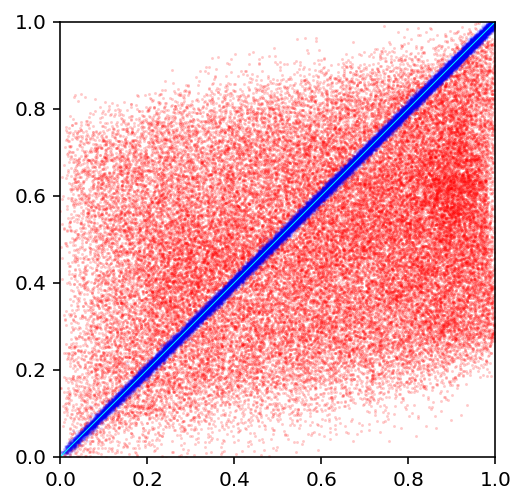

In [44]:
plt.plot(x[0:B_plot,:,T_st:].flatten(), torch.matmul(P_temp, x_init[...,T_st:]).data.numpy().flatten(),'r.',markersize=1,alpha=0.2)
plt.plot(x[0:B_plot,:,T_st:].flatten(), torch.matmul(P_temp, x_hat[...,T_st:]).data.numpy().flatten(),'b.',markersize=1,alpha=0.1)
plt.plot([0,1],[0,1],color='cyan',linewidth=0.5)
plt.axis('square')
plt.axis([0,1,0,1])
#plt.savefig('latent_dynamics.png',dpi=300)
plt.show()

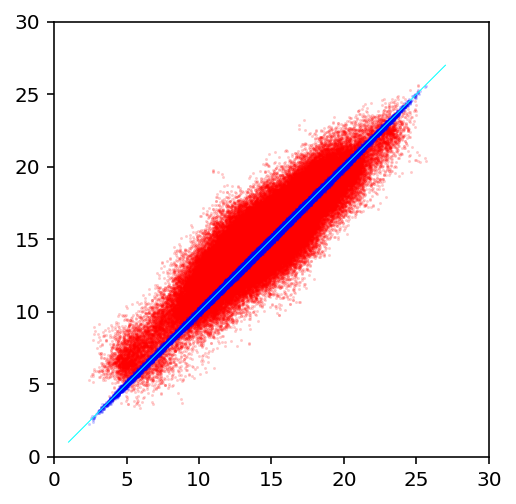

In [46]:
plt.plot(r_brain[0:B_plot,:,T_st:].data.numpy().flatten(),r_init[...,T_st:].data.numpy().flatten(),'r.',markersize=1,alpha=0.2)
plt.plot(r_brain[0:B_plot,:,T_st:].data.numpy().flatten(),r_hat_[...,T_st:].flatten(),'b.',markersize=1,alpha=0.2)
plt.plot([rmin,rmax],[rmin,rmax],color='cyan',linewidth=0.5)
plt.axis('square')

#plt.axis([0,30,0,30])
#plt.savefig('neural_dynamics.png',dpi=300)
plt.show()

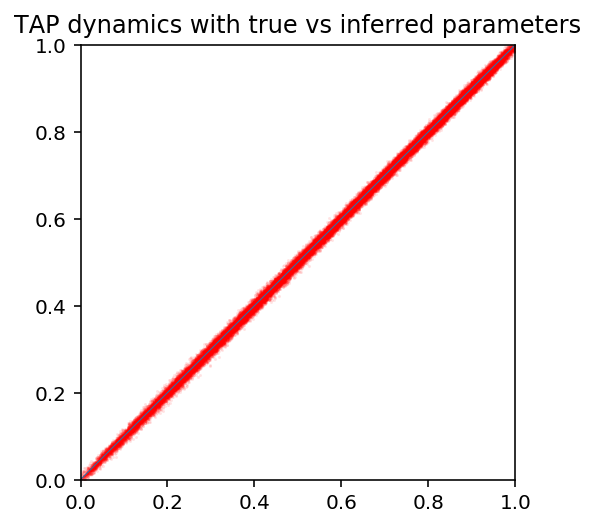

In [47]:
plt.plot(truth,test,'r.',markersize=1,alpha=0.1)
plt.plot([0,1],[0,1],linewidth=0.5)
plt.title('TAP dynamics with true vs inferred parameters')
plt.axis('square')
plt.axis([0,1,0,1])
#plt.savefig('Test_dynamics.png',dpi=300)
plt.show()

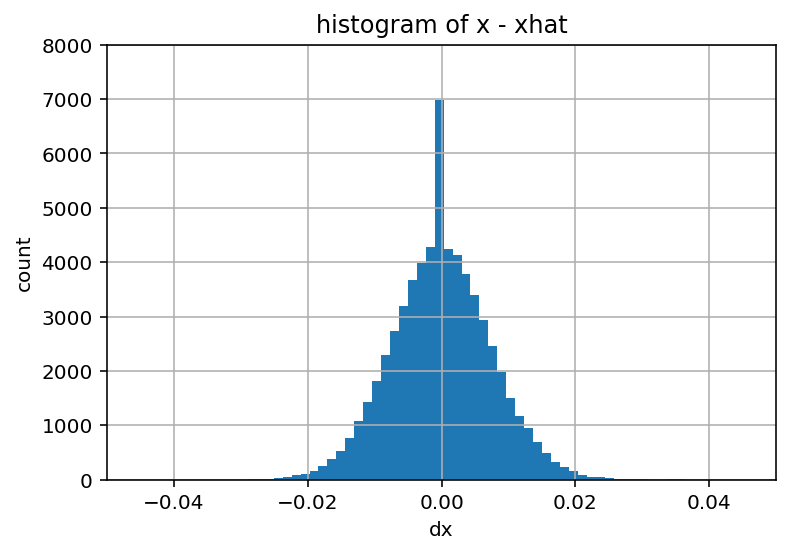

In [51]:
plt.hist(truth-test,50)
plt.xlabel('dx')
plt.ylabel('count')
plt.title('histogram of x - xhat')
plt.grid(True)
#plt.axis([-0.05,0.05,0,8000])
#plt.savefig('Histogram_TestError.pdf')

In [52]:
"""
save all the required variables
"""

params['Q_obs'] = Q_obs

# initial values of parameters
init_parameters = {'G_init':G_init, 'J_init':J_init, 'U_init':U_init, 'V_init':V_init, 'b_init':b_init}

# inferred parameters
inferred_parameters = {'G_hat':G_hat, 'J_hat':J_hat, 'U_hat':U_hat, 'V_hat':V_hat, 'b_hat':b_hat }

fname = 'inference_' + brain_name +'.pkl'

with open(fname, 'wb') as f:  
    pickle.dump([theta, params, init_parameters, inferred_parameters], f)
f.close()

In [53]:
fname

'inference_Ns_25_noiseseed_4021.pkl'